In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn


from preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from nmf import nmf, nmf_sklearn, semi_nmf, sym_nmf, rgnmf_multi, kernel_nmf, sparse_nmf
from clustering_algos import kmeans, gaussian_mixture, spectral_clustering
from visualizing import plot_residuals

from deepnmf import DeepNMF, DeepNMFLoss, DANMF, DANMFLoss

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# list of datasets
# ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'Car', 'CBF', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'DiatomSizeReduction', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'GunPoint', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECGThorax1', 'NonInvasiveFatalECGThorax2', 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarLightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga', 'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In [3]:
dataset = load_ts_dataset('Beef')
data, true_labels = dataset[0], dataset[1]
dist = distance_matrix(data)


In [4]:
Anp = epsilon_graph_hard(dist, epsilon=np.max(dist) + 1)
print(np.mean(dist))
#Anp = epsilon_graph_mean(dist)

0.12212592352229737


In [249]:
np.sum(np.where(Anp == 0.0, 1, 0))/len(Anp.flatten())

0.382598

In [244]:
Anp = dist * np.random.binomial(1, (1 - dist/np.max(dist)))

(array([63632., 62146., 61458., 97130., 82196., 45068., 34502., 55786.,
        59884., 68174., 91490., 87910., 76640., 54772., 27920., 13452.,
         9082.,  5646.,  2332.,   780.]),
 array([0.        , 0.04366819, 0.08733639, 0.13100458, 0.17467278,
        0.21834097, 0.26200917, 0.30567736, 0.34934556, 0.39301375,
        0.43668194, 0.48035014, 0.52401833, 0.56768653, 0.61135472,
        0.65502292, 0.69869111, 0.74235931, 0.7860275 , 0.82969569,
        0.87336389]),
 <BarContainer object of 20 artists>)

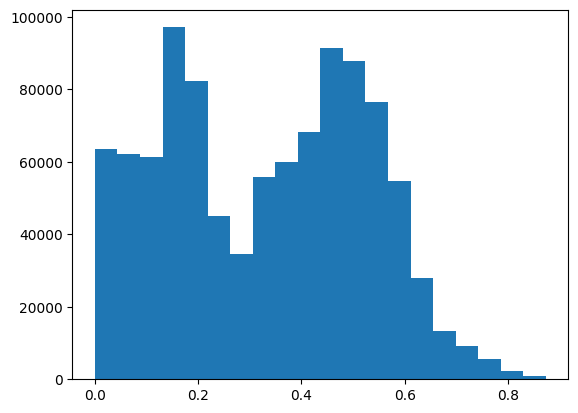

In [256]:
def softm(arr):
    ex = np.exp(arr)
    return ex / np.sum(ex)

def modif(arr):
    print(np.max(arr))
    return arr/np.max(arr)

plt.hist(dist.flatten(), bins=20)

In [199]:
# Hyperparameters
n = len(dist)
nb_clusters = 2
shapes = [n, n//4, n//16, nb_clusters]
sparsity_regularization = 1.0

# graph laplacian
W = np.where(Anp > 0, -1, 0)
D = - np.diag(np.sum(W, axis=0))
L = torch.from_numpy(D + W).contiguous().float()
A = torch.from_numpy(Anp).contiguous().float()

# Model
model = DANMF(shapes)
model.initialize_weights(A)

loss_fn = DANMFLoss(regularization=sparsity_regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
lrs = []

# Infer before
clusters_before = model.infer_clusters()

Layer 1
Layer 2
Layer 3


tensor([0.1274, 0.0308, 0.0891, 0.2283, 0.1512, 0.1998, 0.0400, 0.1260, 0.1063,
        0.3559, 0.2569, 0.4663, 0.2996, 0.1598, 0.7001, 0.2392, 0.0265, 0.1761,
        0.1663, 0.2318, 0.1486, 0.1202, 0.6618, 0.2880, 0.0494, 0.2491, 0.3587,
        0.1881, 0.0914, 0.0462, 0.4381, 0.3033, 0.3626, 0.5438, 0.0590, 0.4472,
        0.3716, 0.1314, 0.1654, 0.1402, 0.4408, 0.3828, 0.4279, 0.3506, 0.1455,
        0.1855, 0.3848, 0.2463, 0.1959, 0.0563, 0.1348, 0.4665, 0.2565, 0.3069,
        0.1774, 0.3542, 0.4507, 0.1577, 0.1476, 0.1887, 0.1181, 0.1376, 0.1235,
        0.1793, 0.2205, 0.2975, 0.0935, 0.1267, 0.0789, 0.1863, 0.1184, 0.3549,
        0.2029, 0.2611, 0.3578, 0.1472, 0.2640, 0.4846, 0.1653, 0.1500, 0.2644,
        0.2411, 0.4122, 0.2067, 0.1140, 0.1967, 0.1884, 0.1584, 0.1258, 0.3712,
        0.0859, 0.2741, 0.1104, 0.0706, 0.1361, 0.0406, 0.5528, 0.3706, 0.3129,
        0.2308, 0.2380, 0.2436, 0.3497, 0.3675, 0.3251, 0.5662, 0.1953, 0.2722,
        0.1320, 0.1927, 0.2672, 0.2957, 

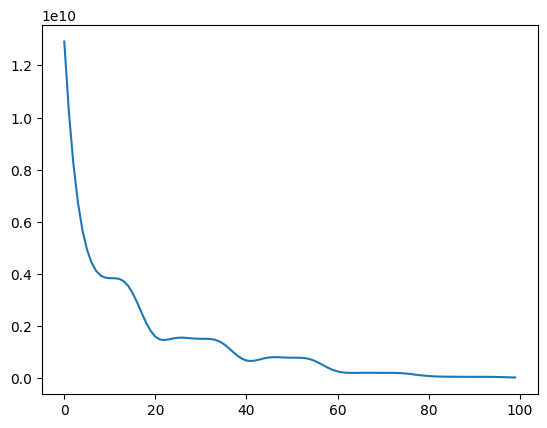

In [200]:
# Zero your gradients for every batch!
optimizer.zero_grad()

# Make predictions for this batch
outputs = model()
print(outputs[0, :])

# Compute the loss and its gradients
losses = []
for step in range(100):
    outputs = model()
    loss = loss_fn(outputs, model.approx_vp(A), A, model.vp(), L)
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
    # def closure():
    #     optimizer.zero_grad()
    #     outputs = model()
    #     loss = loss_fn(outputs, torch.Tensor(A))
    #     loss.backward()
    #     return loss
    # # Adjust learning weights
    # optimizer.step(closure)
    
print(outputs[0, :])
plt.plot(losses)

In [11]:
deep_nmf(Anp, 5)
deep_autoencoder_nmf(Anp, 5)

Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Layer 1
Layer 2
Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(array([[1.16049552e-17, 2.23525241e-02, 1.71871558e-01, 2.43646026e-01,
         4.54550646e-02],
        [1.78331140e-17, 3.43487002e-02, 2.64111787e-01, 3.74406219e-01,
         6.98499382e-02],
        [1.47635527e-17, 2.84363609e-02, 2.18650997e-01, 3.09960783e-01,
         5.78268729e-02],
        [1.95659879e-17, 3.76864187e-02, 2.89775968e-01, 4.10787910e-01,
         7.66373724e-02],
        [1.29109196e-17, 2.48679686e-02, 1.91213146e-01, 2.71064758e-01,
         5.05703539e-02],
        [1.09074492e-17, 2.10090447e-02, 1.61541373e-01, 2.29001895e-01,
         4.27230261e-02],
        [9.77965547e-18, 1.88367795e-02, 1.44838527e-01, 2.05323860e-01,
         3.83056067e-02],
        [1.07315120e-17, 2.06701700e-02, 1.58935711e-01, 2.25308090e-01,
         4.20339033e-02],
        [1.00562647e-17, 1.93695612e-02, 1.48935169e-01, 2.11131275e-01,
         3.93890478e-02],
        [1.03474744e-17, 1.99304670e-02, 1.53248042e-01, 2.17245221e-01,
         4.05296795e-02],
        [1

# Prediction

In [201]:
clusters_before, predicted_clusters, outputs

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [202]:
predicted_clusters = model.infer_clusters().numpy()
print(rand_score(true_labels, predicted_clusters))
print(adjusted_rand_score(true_labels, clusters_before))


0.8246426426426426
0.0


In [254]:
print(adjusted_rand_score(true_labels, kmeans(Anp, 2)))
w, h, _ = nmf_sklearn(Anp, d=2)
print(adjusted_rand_score(true_labels, np.argmax(w, axis=1)))

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.0022941824734312084
0.0003612663383751461


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [252]:
from sklearn.metrics import accuracy_score

print(accuracy_score(true_labels, kmeans(Anp, 2)))

0.508


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Visualizing

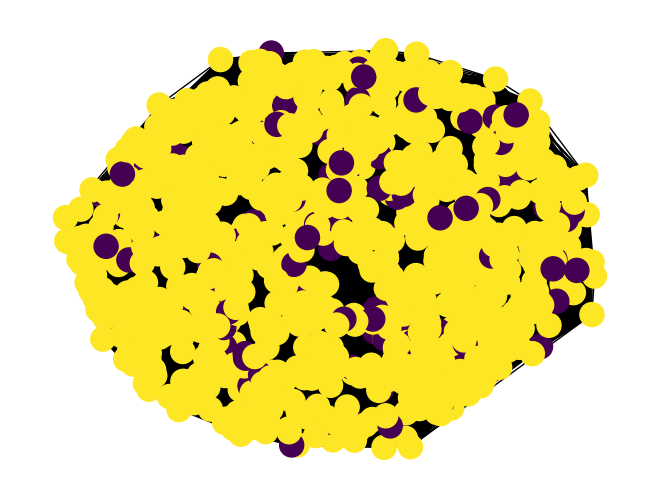

In [245]:
G = nx.from_numpy_array(Anp)
nx.draw(G, node_color=true_labels)
#nx.draw(G, node_color=predicted_clusters)

(1000, 2)


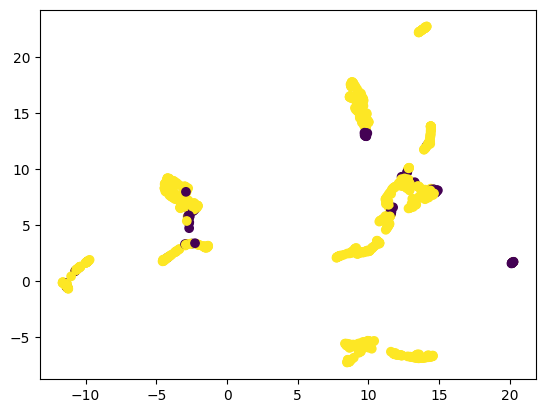

In [156]:

import umap
reducer = umap.UMAP()
reduction = reducer.fit_transform(Anp)
print(reduction.shape)
plt.scatter(reduction[:, 0], reduction[:, 1], c=true_labels)

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


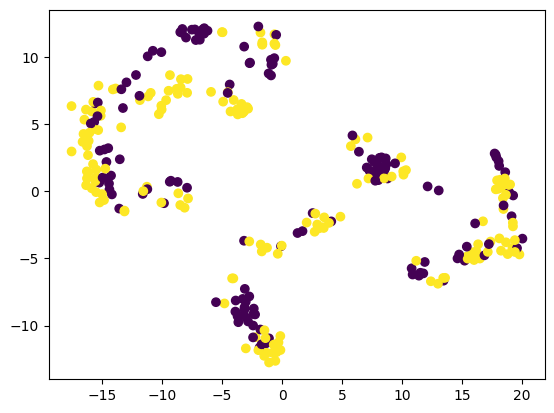

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduction = tsne.fit_transform(Anp)

plt.scatter(reduction[:, 0], reduction[:, 1], c=true_labels)

[3.67187379 1.42573932]


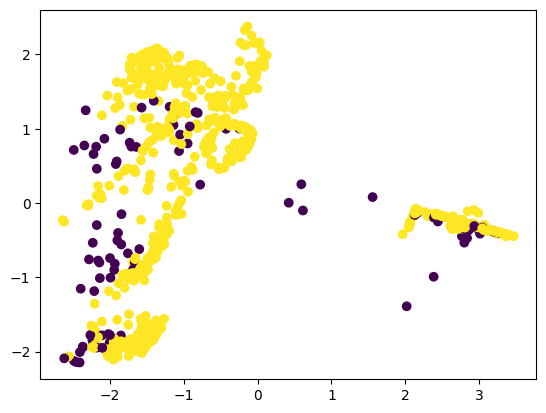

In [155]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduction = pca.fit_transform(Anp)
print(pca.explained_variance_)

plt.scatter(reduction[:, 0], reduction[:, 1], c=true_labels)

In [271]:
true_labels_true = np.where(true_labels<= 0.0, 0, 1)

In [274]:
accs = []
rands = []
adjs = []
eps = []
factor = 0.9
for i in range(100):
    ep = factor**i
    eps.append(ep)
    Anp = epsilon_graph_hard(dist, epsilon=ep)
    predic = kmeans(Anp, d=2)
    accs.append(accuracy_score(true_labels_true, predic))
    rands.append(rand_score(true_labels_true, predic))
    adjs.append(adjusted_rand_score(true_labels_true, predic))

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default valu

In [275]:
true_labels_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

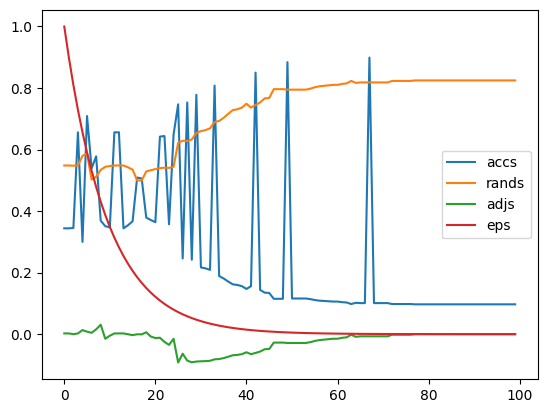

In [276]:
plt.plot(accs, label='accs')
plt.plot(rands, label='rands')
plt.plot(adjs, label='adjs')
plt.plot(eps, label='eps')
plt.legend()

In [277]:
i = 2
print(i in range(3))

True
